In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\andyd\Udesa\Machine Learning\Proyecto-final-ML\entrenamientos_df_intermedio


In [13]:
# Cargar dataset
dataset1 = pd.read_csv('../dataset_basico.csv')
dataset2 = pd.read_csv('../datasetintermedio.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']
X2, y2 = dataset2.drop(columns='Precio_usd'), dataset2['Precio_usd']


x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [14]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint, uniform
import numpy as np

# RMSE negativo para GridSearch
neg_rmse = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=True
)

# Hiperparámetros a buscar
param_dist = {
    "n_estimators":      randint(200, 1200),
    "max_depth":         randint(4, 40),
    "max_features":      uniform(0.3, 0.7),
    "min_samples_split": randint(2, 15),
    "min_samples_leaf":  randint(1, 10)
}


In [16]:
search1 = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring=neg_rmse,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search1.fit(x1_train, y1_train)
print("✅ Dataset 1 - Mejor RMSE CV:", -search1.best_score_)
print("Hiperparámetros óptimos modelo 1:", search1.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Dataset 1 - Mejor RMSE CV: 4727.98382718416
Hiperparámetros óptimos modelo 1: {'max_depth': 24, 'max_features': 0.5720741027826374, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 991}


In [18]:
search2 = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring=neg_rmse,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search2.fit(x2_train, y2_train)
print("✅ Dataset 2 - Mejor RMSE CV:", -search2.best_score_)
print("Hiperparámetros óptimos modelo 2:", search2.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Dataset 2 - Mejor RMSE CV: 7574.489832168076
Hiperparámetros óptimos modelo 2: {'max_depth': 24, 'max_features': 0.5720741027826374, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 991}


In [19]:
# Modelo 1
model_1 = search1.best_estimator_
model_1.fit(x1_train, y1_train)
y1_pred = model_1.predict(x1_test)
rmse_1 = np.sqrt(mean_squared_error(y1_test, y1_pred))

# Modelo 2
model_2 = search2.best_estimator_
model_2.fit(x2_train, y2_train)
y2_pred = model_2.predict(x2_test)
rmse_2 = np.sqrt(mean_squared_error(y2_test, y2_pred))


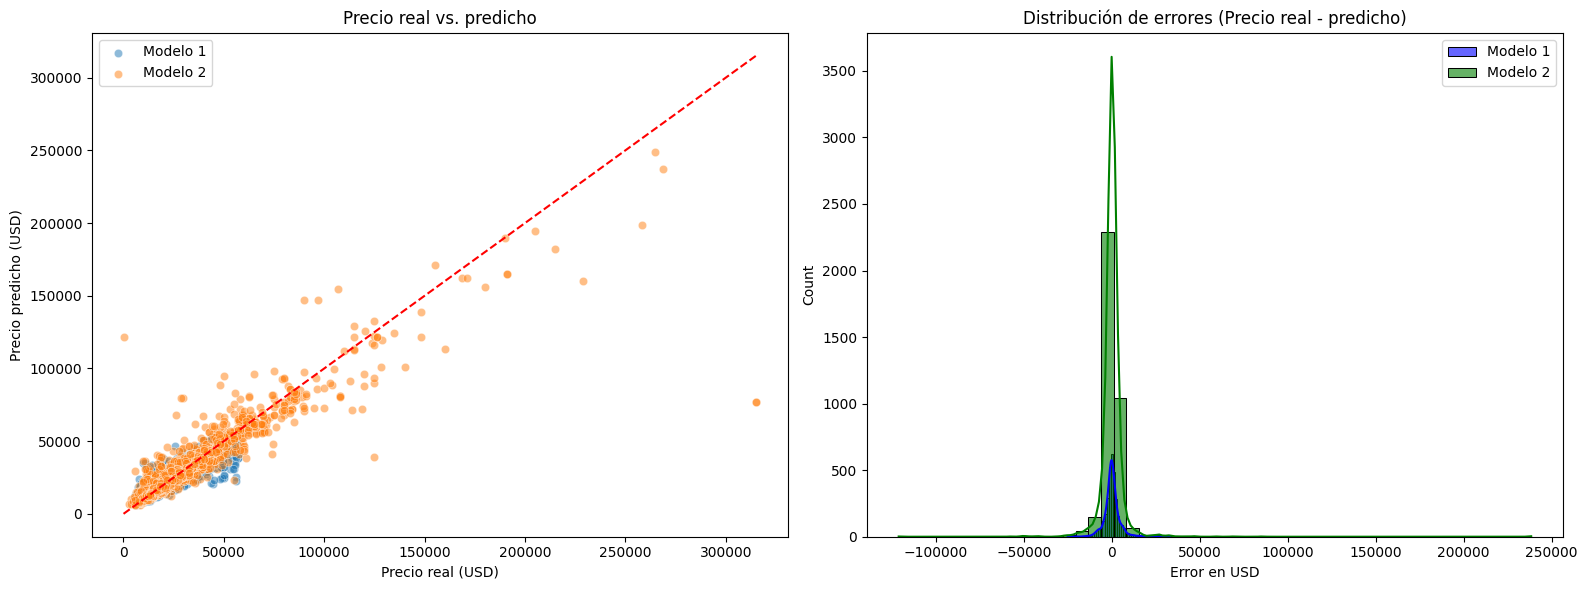

In [20]:
# Errores
errores_1 = y1_test - y1_pred
errores_2 = y2_test - y2_pred

# Métricas
from sklearn.metrics import mean_absolute_error, r2_score

mae1 = mean_absolute_error(y1_test, y1_pred)
r21 = r2_score(y1_test, y1_pred)

mae2 = mean_absolute_error(y2_test, y2_pred)
r22 = r2_score(y2_test, y2_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ------------------------
# Gráfico 1: Real vs. Predicho
# ------------------------
sns.scatterplot(ax=axes[0], x=y1_test, y=y1_pred, label='Modelo 1', alpha=0.5)
sns.scatterplot(ax=axes[0], x=y2_test, y=y2_pred, label='Modelo 2', alpha=0.5)

# Línea ideal (predicción perfecta)
min_val = min(y1_test.min(), y2_test.min())
max_val = max(y1_test.max(), y2_test.max())
axes[0].plot([min_val, max_val], [min_val, max_val], '--', color='red')

axes[0].set_title("Precio real vs. predicho")
axes[0].set_xlabel("Precio real (USD)")
axes[0].set_ylabel("Precio predicho (USD)")
axes[0].legend()

# ------------------------
# Gráfico 2: Histograma de errores
# ------------------------
sns.histplot(errores_1, bins=50, kde=True, label='Modelo 1', ax=axes[1], color='blue', alpha=0.6)
sns.histplot(errores_2, bins=50, kde=True, label='Modelo 2', ax=axes[1], color='green', alpha=0.6)

axes[1].set_title("Distribución de errores (Precio real - predicho)")
axes[1].set_xlabel("Error en USD")
axes[1].legend()

# ------------------------
plt.tight_layout()
plt.show()

